# Liver Disease Prediction using Machine Learning

**Course:** CU6051NI – Artificial Intelligence  
**Student Name:** Pranay Shakya  
**London Met ID:** 23050330  

## Algorithms Used
- K-Nearest Neighbor (KNN)
- Logistic Regression
- Random Forest
- XGBoost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE

In [2]:
#loading csv file
df = pd.read_csv("liver_disease_dataset.csv")

In [3]:
# Handle missing values
df.replace("NA", np.nan, inplace=True)
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

In [4]:
# Remove redundant columns
columns_to_drop = ['id', 'weight', 'height', 'Unnamed: 0']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop)

print(f"\nFinal shape: {df.shape}")
print(f"Final columns: {df.columns.tolist()}")


Final shape: (18011, 6)
Final columns: ['age', 'male', 'bmi', 'case.id', 'futime', 'status']


In [5]:
df.head()

,age,male,bmi,case.id,futime,status
0,57,0,22.690939,10630.0,6261,0
1,67,0,24.884028,14817.0,624,0
2,53,1,30.453537,3.0,1783,0
3,56,1,37.830100,6628.0,3143,0
4,68,1,28.828876,1871.0,1836,1


In [6]:
#class imbalance analysis 
target_column = "status"

print("\n" + "="*40)
print("CLASS IMBALANCE ANALYSIS")
print("="*40)
print(f"Class Distribution:\n{df[target_column].value_counts()}")
print(f"\nClass Proportions:\n{df[target_column].value_counts(normalize=True)}")

class_counts = df[target_column].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")


CLASS IMBALANCE ANALYSIS
Class Distribution:
status
0    16629
1     1382
Name: count, dtype: int64

Class Proportions:
status
0    0.923269
1    0.076731
Name: proportion, dtype: float64

Class Imbalance Ratio: 12.03:1


In [7]:
#train test split
X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# SMOTE for data balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE: {pd.Series(y_train_balanced).value_counts().to_dict()}")

After SMOTE: {0: 13302, 1: 13302}


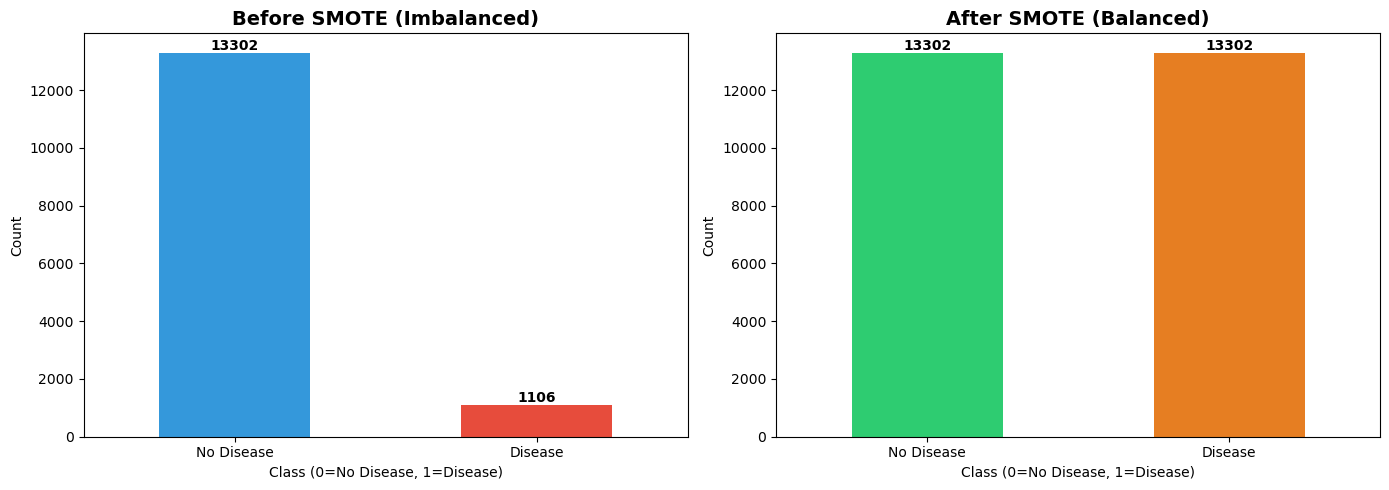

In [23]:
# Create balanced dataframe
df_balanced = pd.DataFrame(X_train_balanced, columns=X.columns)
df_balanced[target_column] = y_train_balanced

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Before SMOTE (Imbalanced)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=No Disease, 1=Disease)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Disease', 'Disease'], rotation=0)
for i, v in enumerate(pd.Series(y_train).value_counts().values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e67e22'])
axes[1].set_title('After SMOTE (Balanced)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class (0=No Disease, 1=Disease)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Disease', 'Disease'], rotation=0)
for i, v in enumerate(pd.Series(y_train_balanced).value_counts().values):
    axes[1].text(i, v + 100, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

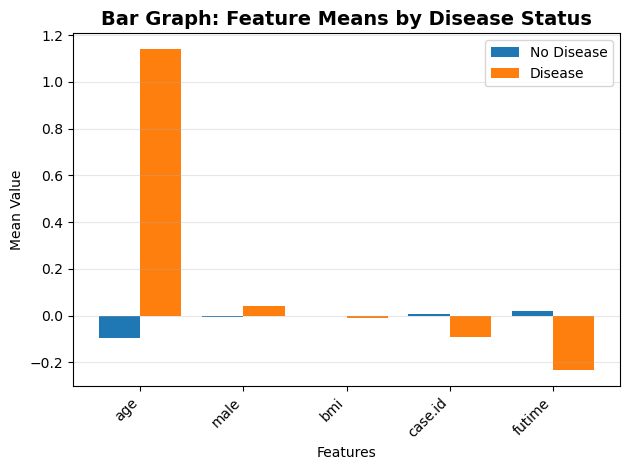

In [11]:
# Bar Graph
plt.figure(figsize=(12, 6))
df_balanced.groupby(target_column).mean().T.plot(kind='bar', width=0.8)
plt.title('Bar Graph: Feature Means by Disease Status', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.legend(['No Disease', 'Disease'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

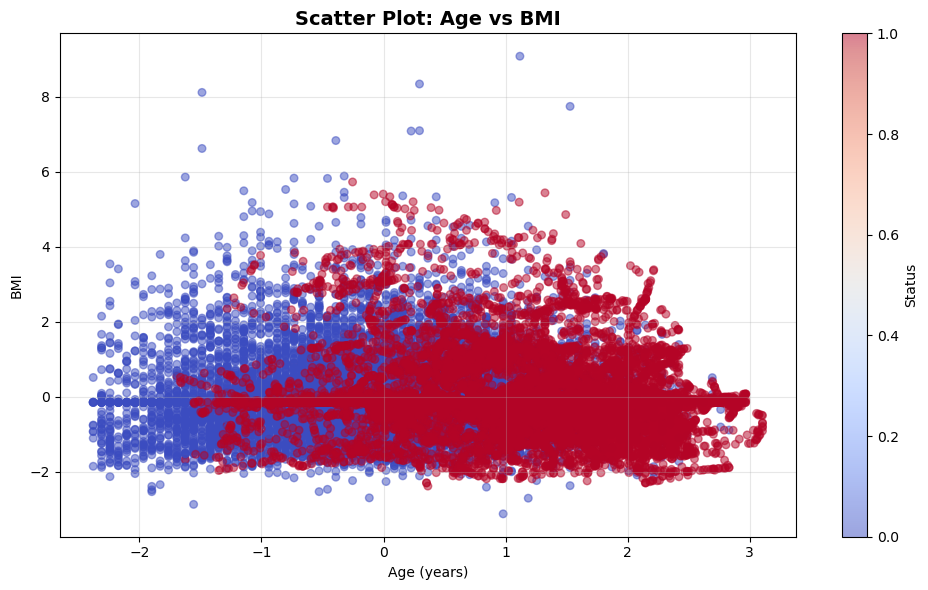

In [12]:
# Scatter Plot
if 'age' in df_balanced.columns and 'bmi' in df_balanced.columns:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_balanced['age'], df_balanced['bmi'], 
                         c=df_balanced[target_column], cmap='coolwarm', alpha=0.5, s=30)
    plt.colorbar(scatter, label='Status')
    plt.xlabel('Age (years)')
    plt.ylabel('BMI')
    plt.title('Scatter Plot: Age vs BMI', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

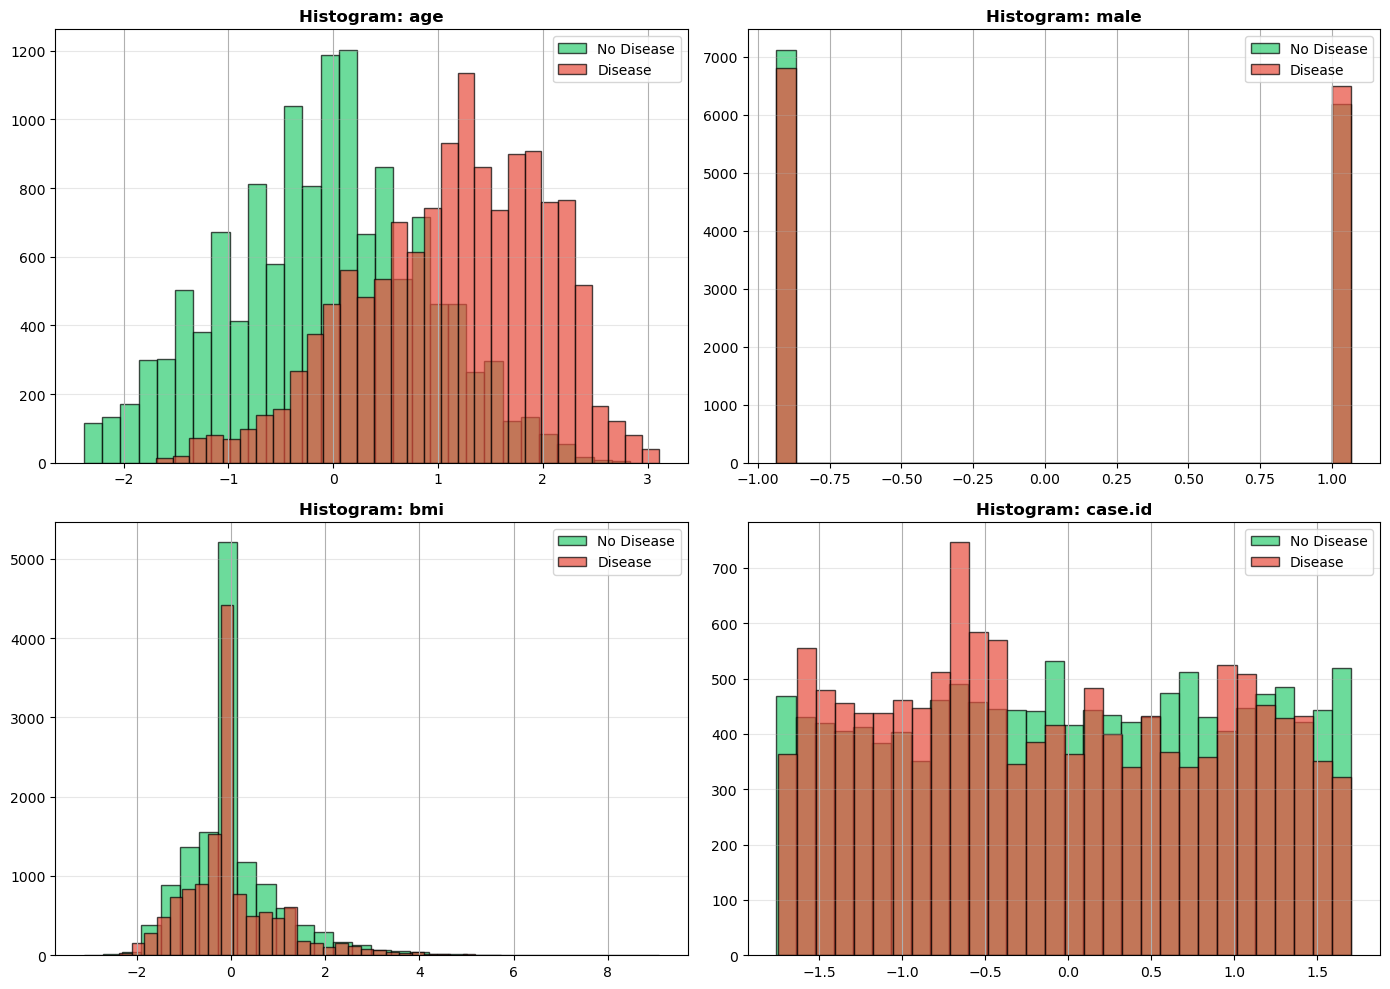

In [13]:
# Histogram
features = list(X.columns)[:4]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for idx, feature in enumerate(features):
    df_balanced[df_balanced[target_column]==0][feature].hist(
        bins=30, alpha=0.7, ax=axes[idx], color='#2ecc71', label='No Disease', edgecolor='black')
    df_balanced[df_balanced[target_column]==1][feature].hist(
        bins=30, alpha=0.7, ax=axes[idx], color='#e74c3c', label='Disease', edgecolor='black')
    axes[idx].set_title(f'Histogram: {feature}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

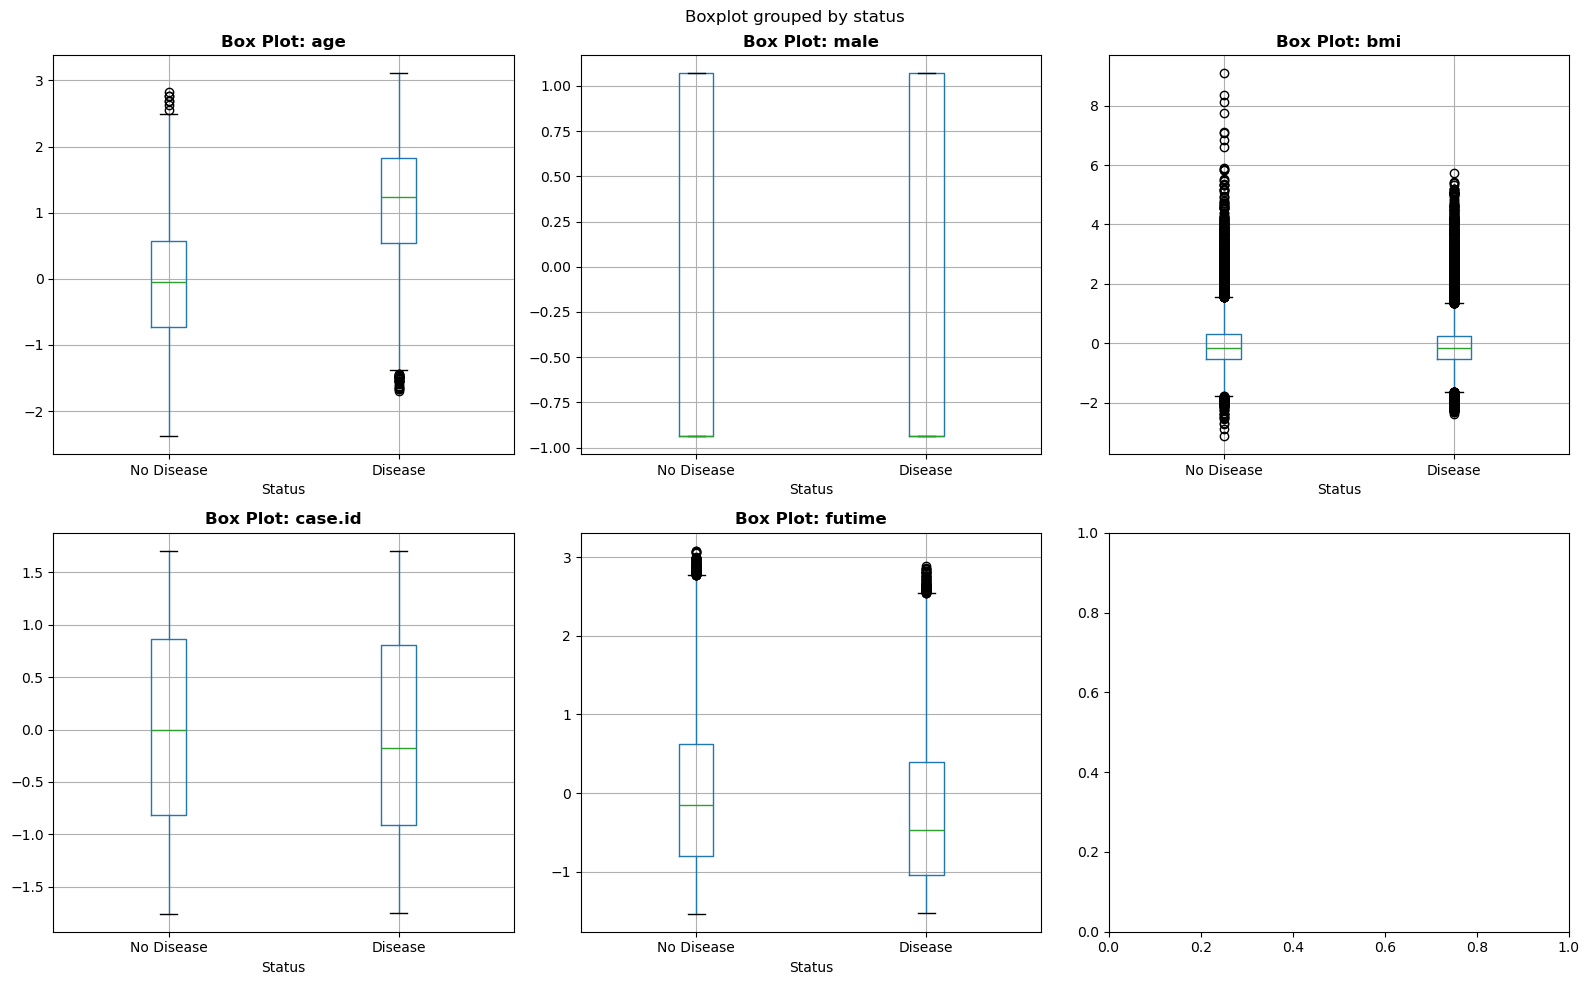

In [14]:
# Box Plot
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()
for idx, feature in enumerate(list(X.columns)[:6]):
    df_balanced.boxplot(column=feature, by=target_column, ax=axes[idx])
    axes[idx].set_title(f'Box Plot: {feature}', fontweight='bold')
    axes[idx].set_xlabel('Status')
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No Disease', 'Disease'])
plt.tight_layout()
plt.show()

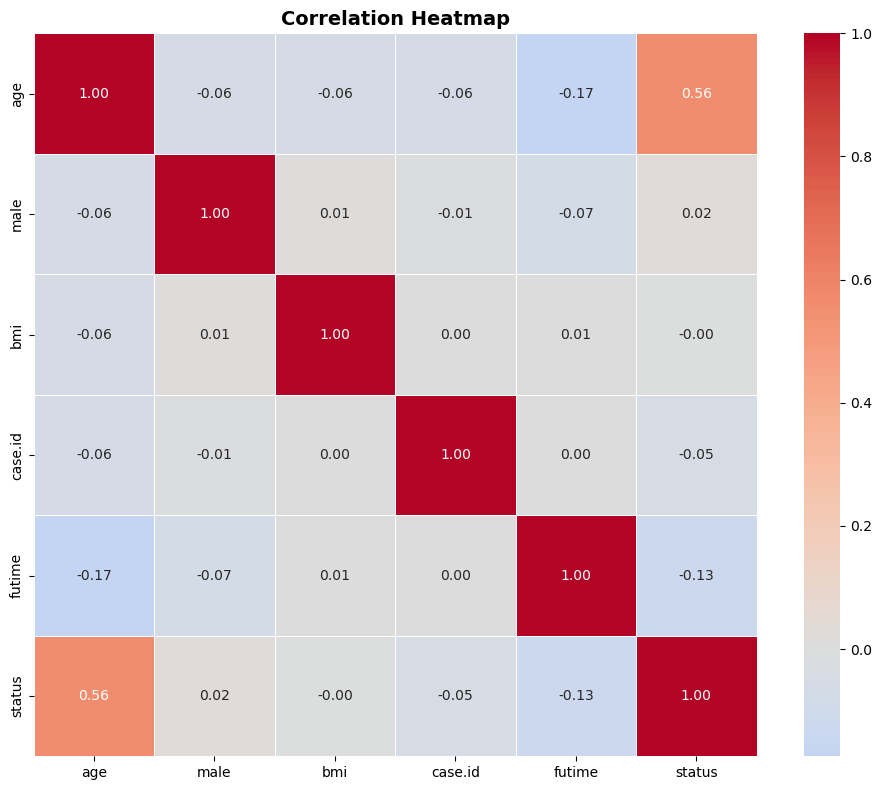

In [15]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_balanced.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
#model training for all algorithms
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

results = {}
predictions = {}
confusion_matrices = {}
cv_scores = {}

for name, model in models.items():
    print(f"Training: {name}...")
    
    if name in ["Random Forest", "XGBoost"]:
        X_train_bal_unscaled, _ = smote.fit_resample(X_train, y_train)
        model.fit(X_train_bal_unscaled, y_train_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        cv_scores[name] = cross_val_score(model, X_train_bal_unscaled, y_train_balanced, cv=5, scoring='f1')
    else:
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        cv_scores[name] = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
    
    predictions[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
        "CV Mean F1": cv_scores[name].mean(),
        "CV Std F1": cv_scores[name].std()
    }
    
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)


MODEL TRAINING
Training: KNN...
Training: Logistic Regression...
Training: Random Forest...
Training: XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:57:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

In [17]:
def plot_algorithm_analysis(model_name, results, predictions, confusion_matrices, cv_scores, y_test, models, X):
    print("\n" + "="*80)
    print(f"ALGORITHM: {model_name}")
    print("="*80)
    
    y_pred = predictions[model_name]['y_pred']
    y_pred_proba = predictions[model_name]['y_pred_proba']
    cm = confusion_matrices[model_name]
    
    # Print metrics
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))
    print(f"\nMetrics: Acc={results[model_name]['Accuracy']:.4f}, "
          f"Prec={results[model_name]['Precision']:.4f}, "
          f"Rec={results[model_name]['Recall']:.4f}, "
          f"F1={results[model_name]['F1-Score']:.4f}, "
          f"AUC={results[model_name]['ROC-AUC']:.4f}")
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Performance Metrics Bar Chart
    ax1 = fig.add_subplot(gs[0, 0])
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    values = [results[model_name][m] for m in metrics]
    bars = ax1.bar(metrics, values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
    ax1.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    ax1.set_ylim([0, 1.0])
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax2,
                xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    ax2.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    # 3. ROC Curve
    ax3 = fig.add_subplot(gs[0, 2])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2.5, label=f'AUC = {results[model_name]["ROC-AUC"]:.3f}', color='#e74c3c')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend(loc='lower right')
    ax3.grid(alpha=0.3)
    
    # 4. Precision-Recall Curve
    ax4 = fig.add_subplot(gs[1, 0])
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2.5, color='#2ecc71')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Cross-Validation Scores
    ax5 = fig.add_subplot(gs[1, 1])
    cv_vals = cv_scores[model_name]
    ax5.bar(range(1, 6), cv_vals, color='#3498db', alpha=0.7)
    ax5.axhline(y=cv_vals.mean(), color='r', linestyle='--', linewidth=2, 
                label=f'Mean: {cv_vals.mean():.3f}')
    ax5.set_xlabel('Fold')
    ax5.set_ylabel('F1-Score')
    ax5.set_title('5-Fold Cross-Validation', fontsize=12, fontweight='bold')
    ax5.set_xticks(range(1, 6))
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    ax5.set_ylim([0, 1.0])
    
    # 6. Confusion Matrix Details
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    tn, fp, fn, tp = cm.ravel()
    text = f"Confusion Matrix Details:\n\n"
    text += f"True Positives:  {tp}\n"
    text += f"True Negatives:  {tn}\n"
    text += f"False Positives: {fp}\n"
    text += f"False Negatives: {fn}\n\n"
    text += f"Sensitivity: {tp/(tp+fn):.4f}\n"
    text += f"Specificity: {tn/(tn+fp):.4f}"
    ax6.text(0.1, 0.5, text, fontsize=11, family='monospace', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # 7. Feature Importance or Summary
    if model_name in ["Random Forest", "XGBoost"]:
        ax7 = fig.add_subplot(gs[2, :])
        feature_imp = pd.DataFrame({
            'Feature': X.columns,
            'Importance': models[model_name].feature_importances_
        }).sort_values('Importance', ascending=True)
        color = '#e74c3c' if model_name == 'XGBoost' else '#27ae60'
        ax7.barh(feature_imp['Feature'], feature_imp['Importance'], color=color)
        ax7.set_xlabel('Importance')
        ax7.set_title('Feature Importance', fontsize=12, fontweight='bold')
        ax7.grid(axis='x', alpha=0.3)
    else:
        ax7 = fig.add_subplot(gs[2, :])
        ax7.axis('off')
        summary = f"{model_name} - Performance Summary\n\n"
        summary += f"{'Metric':<20} {'Score':<10} {'Status':<20}\n{'-'*50}\n"
        for metric in metrics:
            score = results[model_name][metric]
            status = "✓ Excellent" if score > 0.9 else "✓ Good" if score > 0.8 else "⚠ Moderate"
            summary += f"{metric:<20} {score:<10.4f} {status:<20}\n"
        ax7.text(0.5, 0.5, summary, fontsize=11, ha='center', va='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    fig.suptitle(f'{model_name} - Comprehensive Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


ALGORITHM: KNN

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.96      0.83      0.89      3327
     Disease       0.20      0.53      0.29       276

    accuracy                           0.80      3603
   macro avg       0.58      0.68      0.59      3603
weighted avg       0.90      0.80      0.84      3603


Metrics: Acc=0.8049, Prec=0.2039, Rec=0.5326, F1=0.2949, AUC=0.7189


/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/1248127607.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


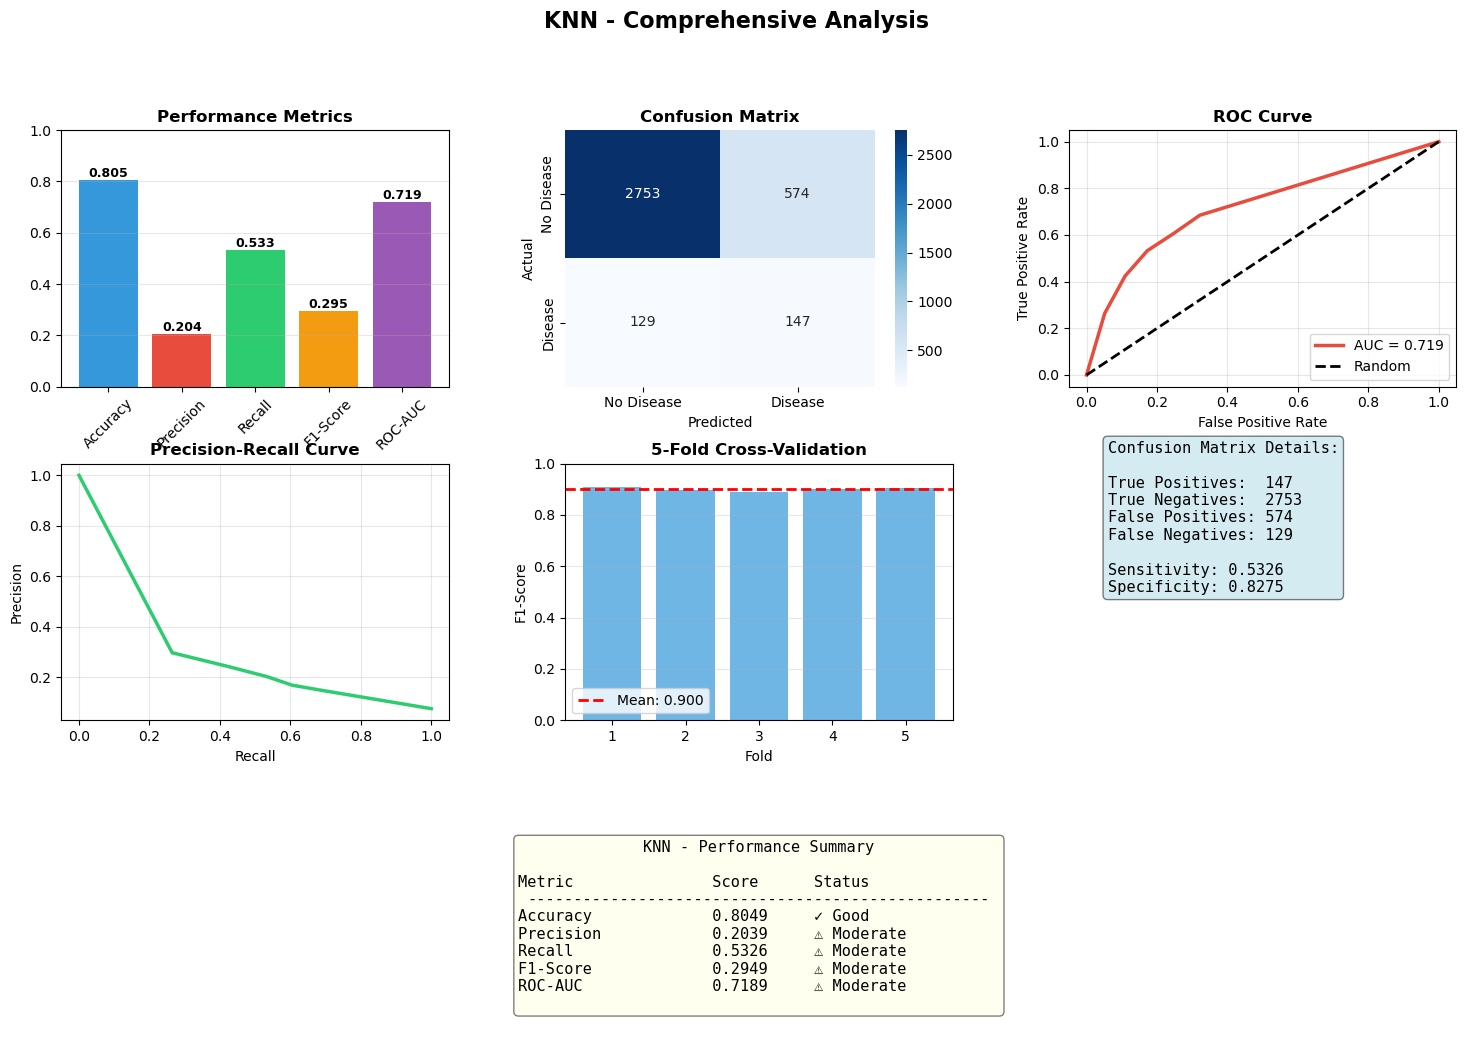

In [18]:
#K-NEAREST NEIGHBOR (KNN) ANALYSIS
plot_algorithm_analysis("KNN", results, predictions, confusion_matrices, cv_scores, y_test, models, X)


ALGORITHM: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.97      0.75      0.85      3327
     Disease       0.19      0.71      0.30       276

    accuracy                           0.75      3603
   macro avg       0.58      0.73      0.57      3603
weighted avg       0.91      0.75      0.80      3603


Metrics: Acc=0.7466, Prec=0.1911, Rec=0.7138, F1=0.3015, AUC=0.8191


/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/1248127607.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


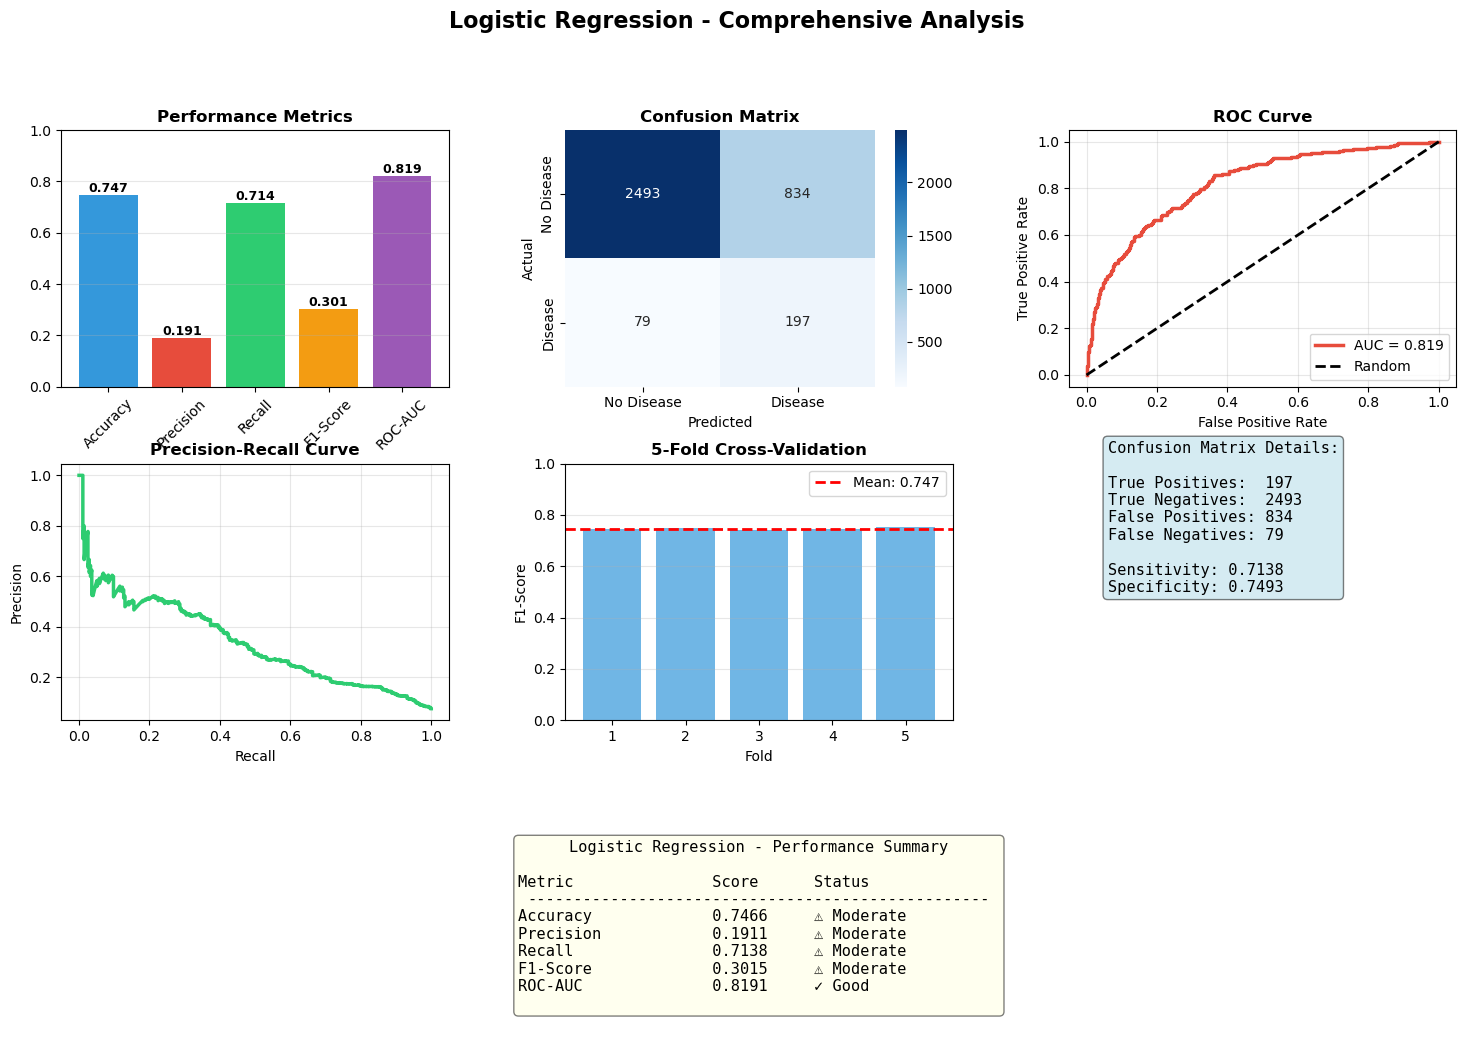

In [19]:
#LOGISTIC REGRESSION ANALYSIS
plot_algorithm_analysis("Logistic Regression", results, predictions, confusion_matrices, cv_scores, y_test, models, X)


ALGORITHM: Random Forest

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.96      0.87      0.91      3327
     Disease       0.25      0.54      0.35       276

    accuracy                           0.84      3603
   macro avg       0.61      0.71      0.63      3603
weighted avg       0.90      0.84      0.87      3603


Metrics: Acc=0.8421, Prec=0.2530, Rec=0.5435, F1=0.3452, AUC=0.7931


/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/1248127607.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


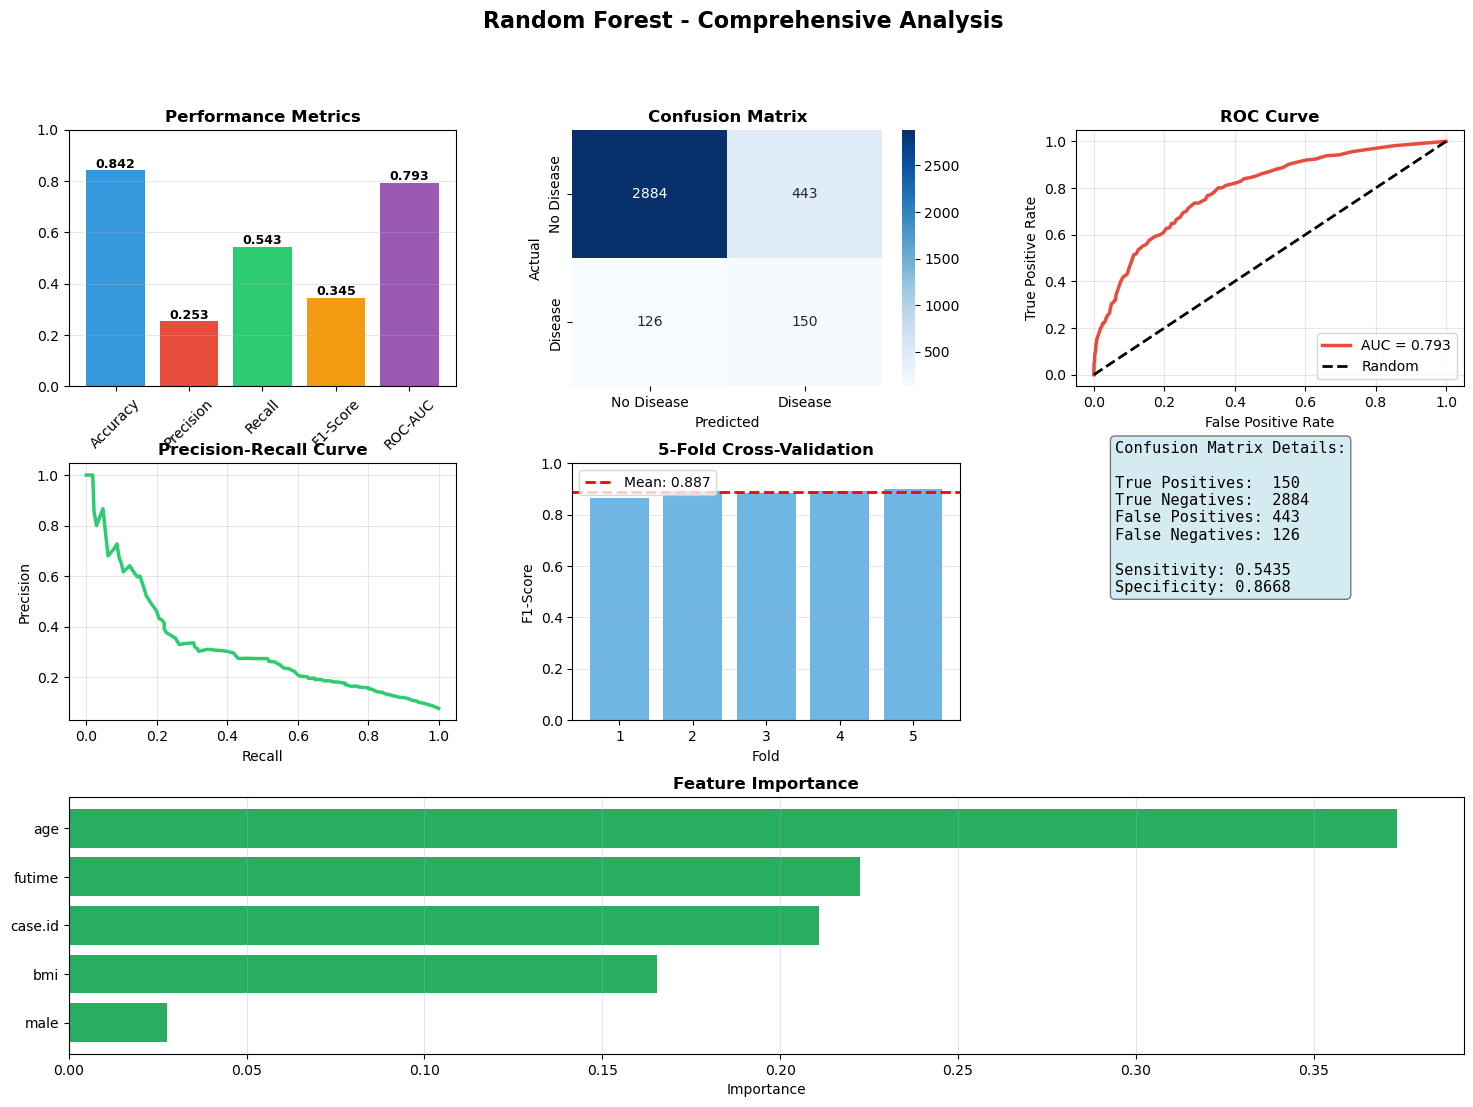

In [20]:
# RANDOM FOREST ANALYSIS
plot_algorithm_analysis("Random Forest", results, predictions, confusion_matrices, cv_scores, y_test, models, X)


ALGORITHM: XGBoost

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.96      0.87      0.91      3327
     Disease       0.24      0.51      0.33       276

    accuracy                           0.84      3603
   macro avg       0.60      0.69      0.62      3603
weighted avg       0.90      0.84      0.86      3603


Metrics: Acc=0.8387, Prec=0.2411, Rec=0.5145, F1=0.3283, AUC=0.7761


/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/1248127607.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


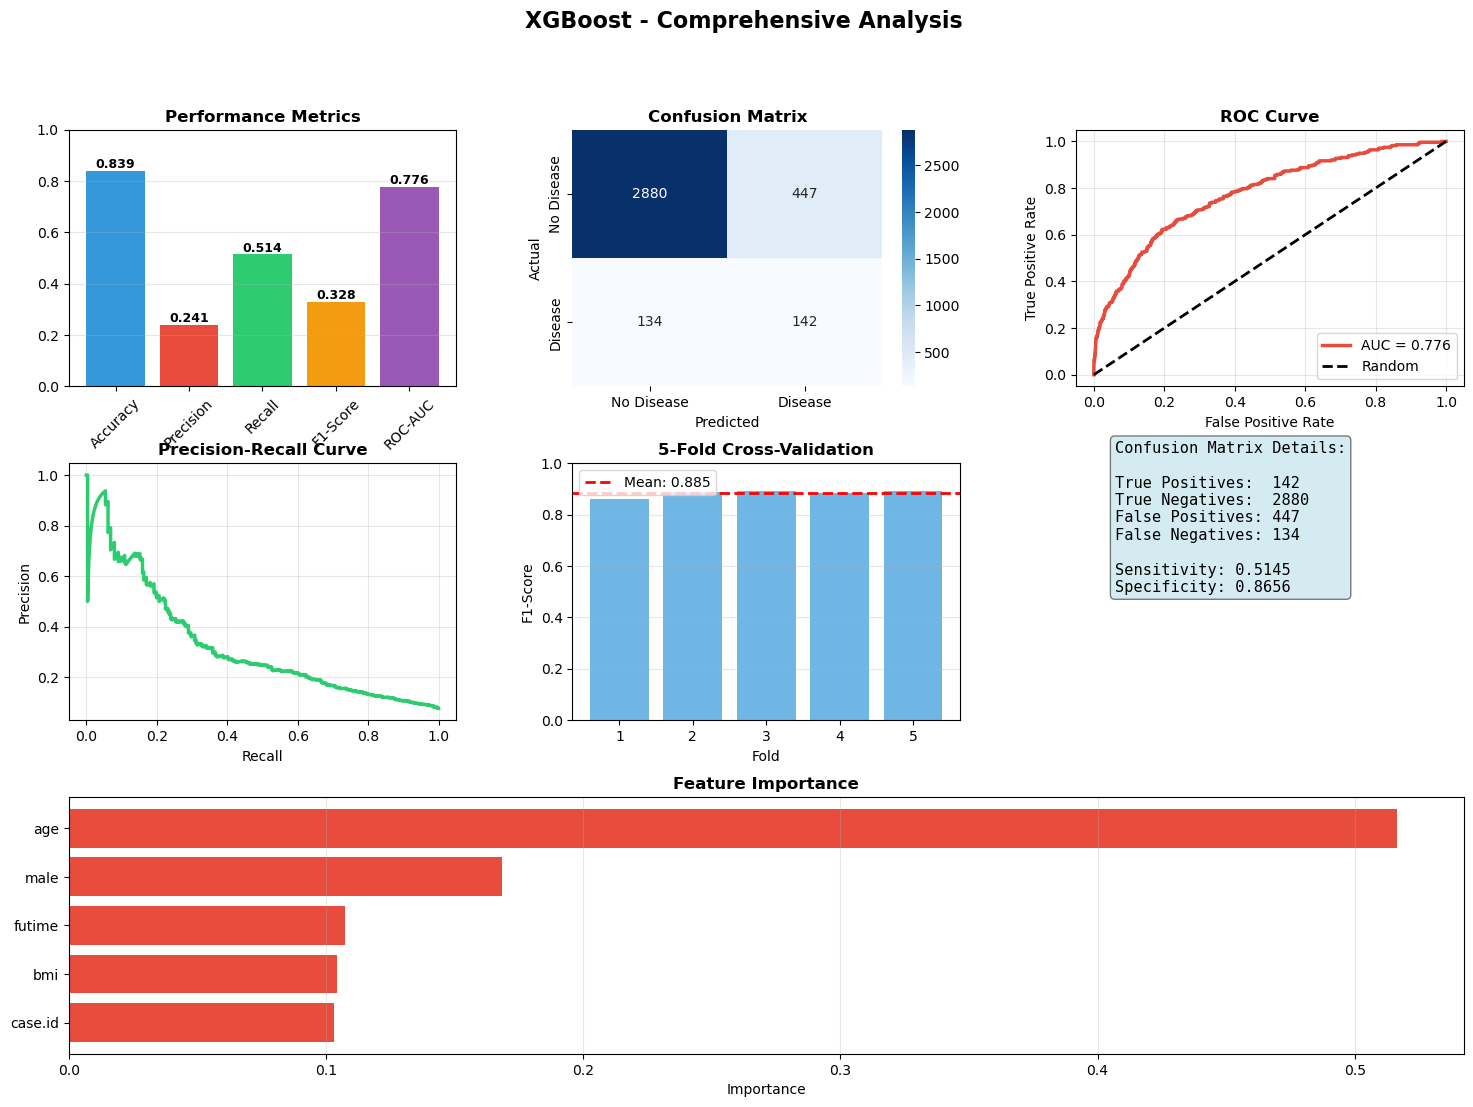

In [21]:
# XGBOOST ANALYSIS
plot_algorithm_analysis("XGBoost", results, predictions, confusion_matrices, cv_scores, y_test, models, X)


OVERALL MODEL COMPARISON

                      Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
KNN                    0.8049     0.2039  0.5326    0.2949   0.7189   
Logistic Regression    0.7466     0.1911  0.7138    0.3015   0.8191   
Random Forest          0.8421     0.2530  0.5435    0.3452   0.7931   
XGBoost                0.8387     0.2411  0.5145    0.3283   0.7761   

                     CV Mean F1  CV Std F1  
KNN                      0.9003     0.0060  
Logistic Regression      0.7466     0.0038  
Random Forest            0.8871     0.0111  
XGBoost                  0.8850     0.0119  


/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/832925617.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(results_df.index, rotation=45, ha='right')
/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/832925617.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(results_df.index, rotation=45, ha='right')
/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/832925617.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(results_df.index, rotation=45, ha='right')
/var/folders/4l/7dt18mg50xq3yzsmqdptkh3c0000gn/T/ipykernel_90068/832925617.py:91: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_lay

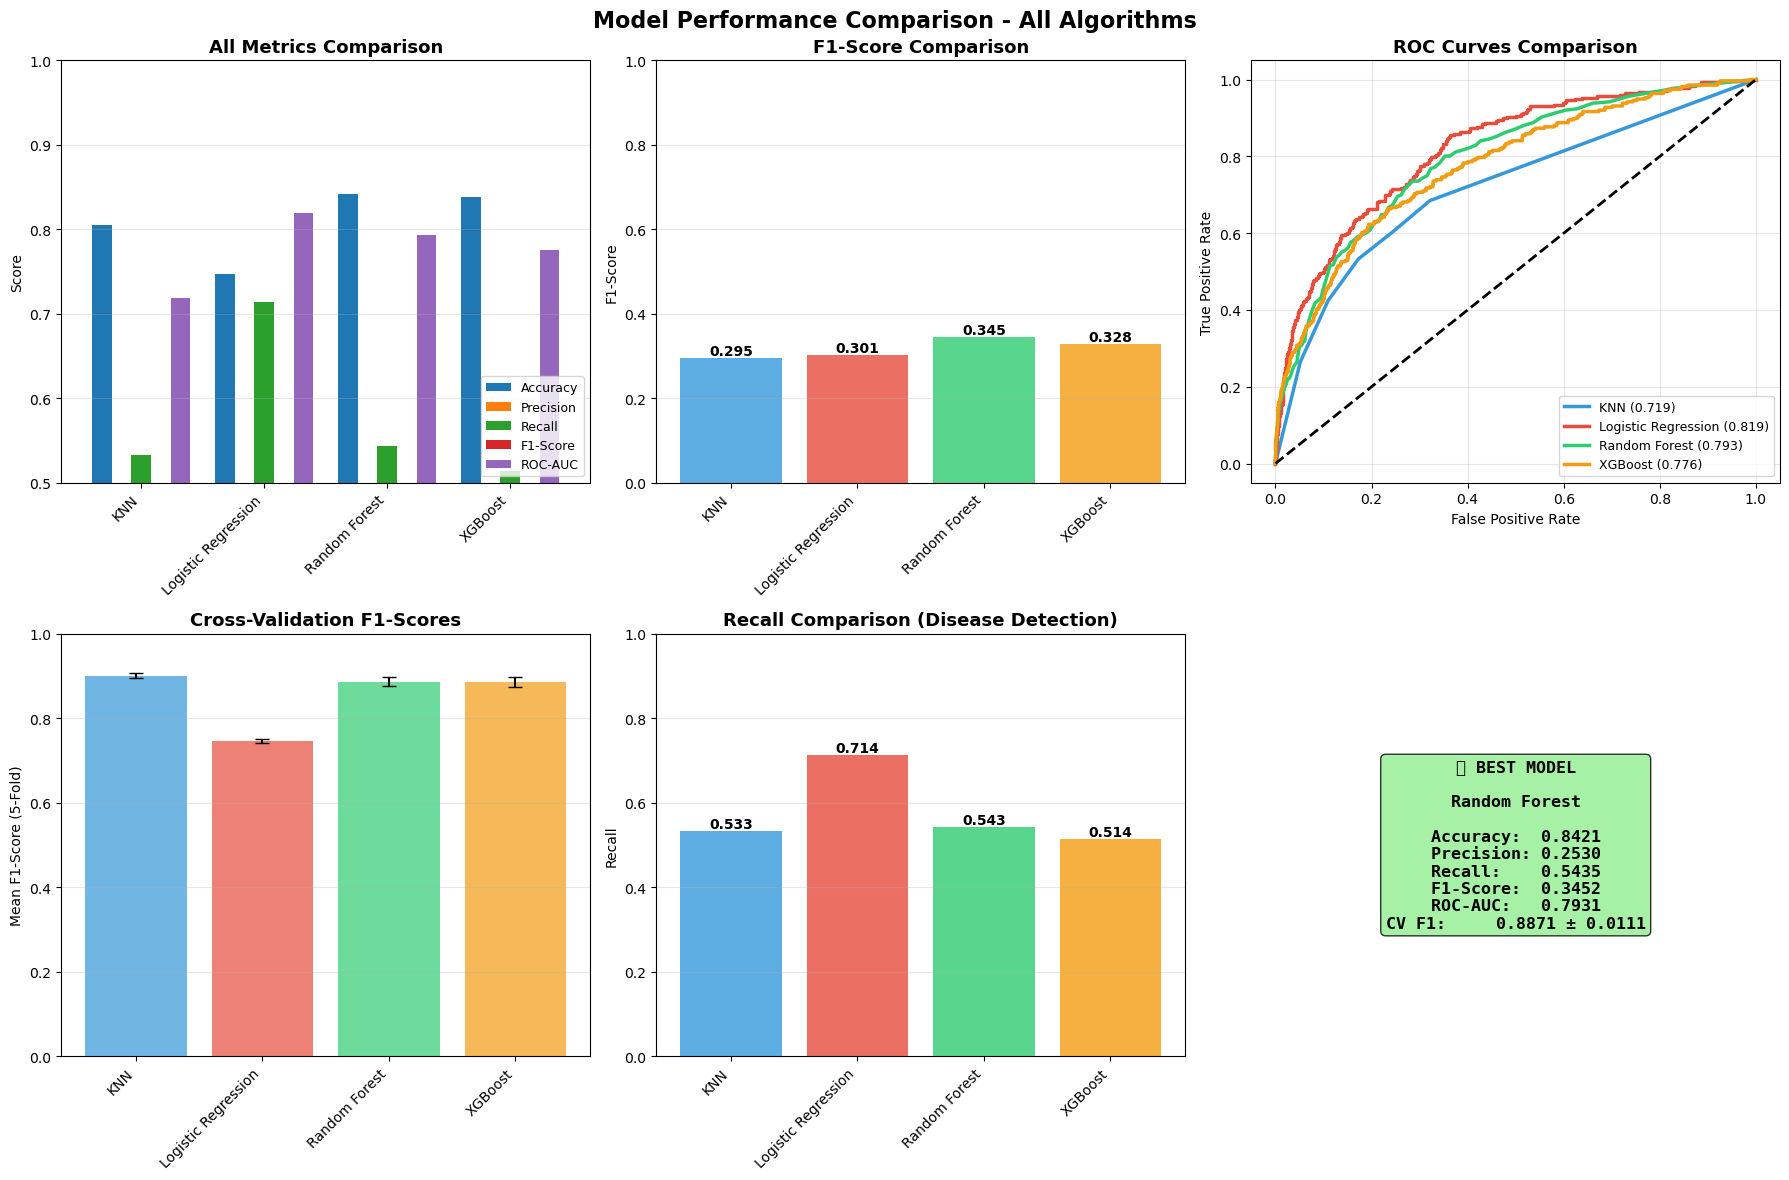

In [22]:
#OVERALL MODEL COMPARISON
print("\n" + "="*80)
print("OVERALL MODEL COMPARISON")
print("="*80)

results_df = pd.DataFrame(results).T
print("\n", results_df.round(4))

# Comparison Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# 1. All Metrics Comparison
ax1 = axes[0, 0]
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('All Metrics Comparison', fontsize=13, fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.5, 1.0])

# 2. F1-Score Comparison
ax2 = axes[0, 1]
bars = ax2.bar(results_df.index, results_df['F1-Score'], color=colors, alpha=0.8)
ax2.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_xticklabels(results_df.index, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.0])
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
            ha='center', va='bottom', fontweight='bold')

# 3. ROC Curves Comparison
ax3 = axes[0, 2]
for idx, model_name in enumerate(models.keys()):
    fpr, tpr, _ = roc_curve(y_test, predictions[model_name]['y_pred_proba'])
    ax3.plot(fpr, tpr, linewidth=2.5, 
            label=f"{model_name} ({results[model_name]['ROC-AUC']:.3f})", 
            color=colors[idx])
ax3.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves Comparison', fontsize=13, fontweight='bold')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(alpha=0.3)

# 4. Cross-Validation Comparison
ax4 = axes[1, 0]
cv_means = [results[name]['CV Mean F1'] for name in models.keys()]
cv_stds = [results[name]['CV Std F1'] for name in models.keys()]
ax4.bar(results_df.index, cv_means, yerr=cv_stds, capsize=5, color=colors, alpha=0.7)
ax4.set_title('Cross-Validation F1-Scores', fontsize=13, fontweight='bold')
ax4.set_ylabel('Mean F1-Score (5-Fold)')
ax4.set_xticklabels(results_df.index, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1.0])

# 5. Recall Comparison
ax5 = axes[1, 1]
bars = ax5.bar(results_df.index, results_df['Recall'], color=colors, alpha=0.8)
ax5.set_title('Recall Comparison (Disease Detection)', fontsize=13, fontweight='bold')
ax5.set_ylabel('Recall')
ax5.set_xticklabels(results_df.index, rotation=45, ha='right')
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 1.0])
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
            ha='center', va='bottom', fontweight='bold')

# 6. Best Model Summary
ax6 = axes[1, 2]
ax6.axis('off')
best_model = results_df['F1-Score'].idxmax()
best_scores = results[best_model]
text = f"🏆 BEST MODEL\n\n{best_model}\n\n"
text += f"Accuracy:  {best_scores['Accuracy']:.4f}\n"
text += f"Precision: {best_scores['Precision']:.4f}\n"
text += f"Recall:    {best_scores['Recall']:.4f}\n"
text += f"F1-Score:  {best_scores['F1-Score']:.4f}\n"
text += f"ROC-AUC:   {best_scores['ROC-AUC']:.4f}\n"
text += f"CV F1:     {best_scores['CV Mean F1']:.4f} ± {best_scores['CV Std F1']:.4f}"
ax6.text(0.5, 0.5, text, fontsize=12, ha='center', va='center', 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
         family='monospace', weight='bold')

plt.suptitle('Model Performance Comparison - All Algorithms', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()